# Read raw data from Wikipedia page

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)
soup  = BeautifulSoup(response.text, 'html.parser')
table = soup.find("table")

l = []
for tr in table.find_all('tr'):
    td = tr.find_all('td')
    if (len(td) == 3):
      row = [tr.text.split('\n')[0] for tr in td]
      l.append(row)
    
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])

In [3]:
print("Dataframe shape:", df.shape)
df.head(12)

Dataframe shape: (288, 3)


,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


# Data Preparation
## Clean not assigned Borough

In [4]:
df = df[df["Borough"] != "Not assigned"]
print("Dataframe shape:", df.shape)
df.head(12)

Dataframe shape: (211, 3)


,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


## Fill not assigned Neighbourhood

In [5]:

df["Neighbourhood"] = np.where(df["Neighbourhood"] == "Not assigned", df["Borough"], df["Neighbourhood"])

df.head(12)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


## Merge Neighbourhood with the same postal code

In [6]:
groups = []
for fields, group in df.groupby(['PostalCode', 'Borough'])['Neighbourhood']:
    neighborhoods = ''.join(str(x) + ", " for x in group.tolist())
    groups.append((fields[0], fields[1], neighborhoods))

df = pd.DataFrame(groups, columns=['PostalCode', 'Borough', 'Neighbourhood'])
print("Dataframe shape:", df.shape)
df.head(12)

Dataframe shape: (103, 3)


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern,"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union,"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill,"
3,M1G,Scarborough,"Woburn,"
4,M1H,Scarborough,"Cedarbrae,"
5,M1J,Scarborough,"Scarborough Village,"
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park,"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge,"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West,"
9,M1N,Scarborough,"Birch Cliff, Cliffside West,"


### Now we have final Neighbourhoods dataframe with 103 records total

## Add geographical coordinates

In [ ]:
!conda config --add channels conda-forge
!conda install geocoder

Solving environment: | 

In [10]:
import geocoder

In [11]:
def get_coord(row):
  coord = None
  while(coord is None):
      a = geocoder.arcgis('{}, Toronto, {}, {}'.format(row['PostalCode'], row['Borough'], row['Neighbourhood']))
      coord = a.latlng
  return coord

def get_latitude(row):
    return get_coord(row)[0]

def get_longitude(row):
    return get_coord(row)[1]

In [12]:
df['Latitude'] = df.apply(get_latitude, axis=1)
df['Longitude'] = df.apply(get_longitude, axis=1)

df.head(12)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern,",43.809770,-79.220840
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union,",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood, Morningside, West Hill,",43.765932,-79.185354
3,M1G,Scarborough,"Woburn,",43.768359,-79.217590
4,M1H,Scarborough,"Cedarbrae,",43.747758,-79.235186
5,M1J,Scarborough,"Scarborough Village,",43.743125,-79.231750
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park,",43.726245,-79.263670
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge,",43.725990,-79.283270
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West,",43.723575,-79.234976
9,M1N,Scarborough,"Birch Cliff, Cliffside West,",43.703793,-79.250598


### Now let's verify coordinates. They are all different and distributed among boroughs

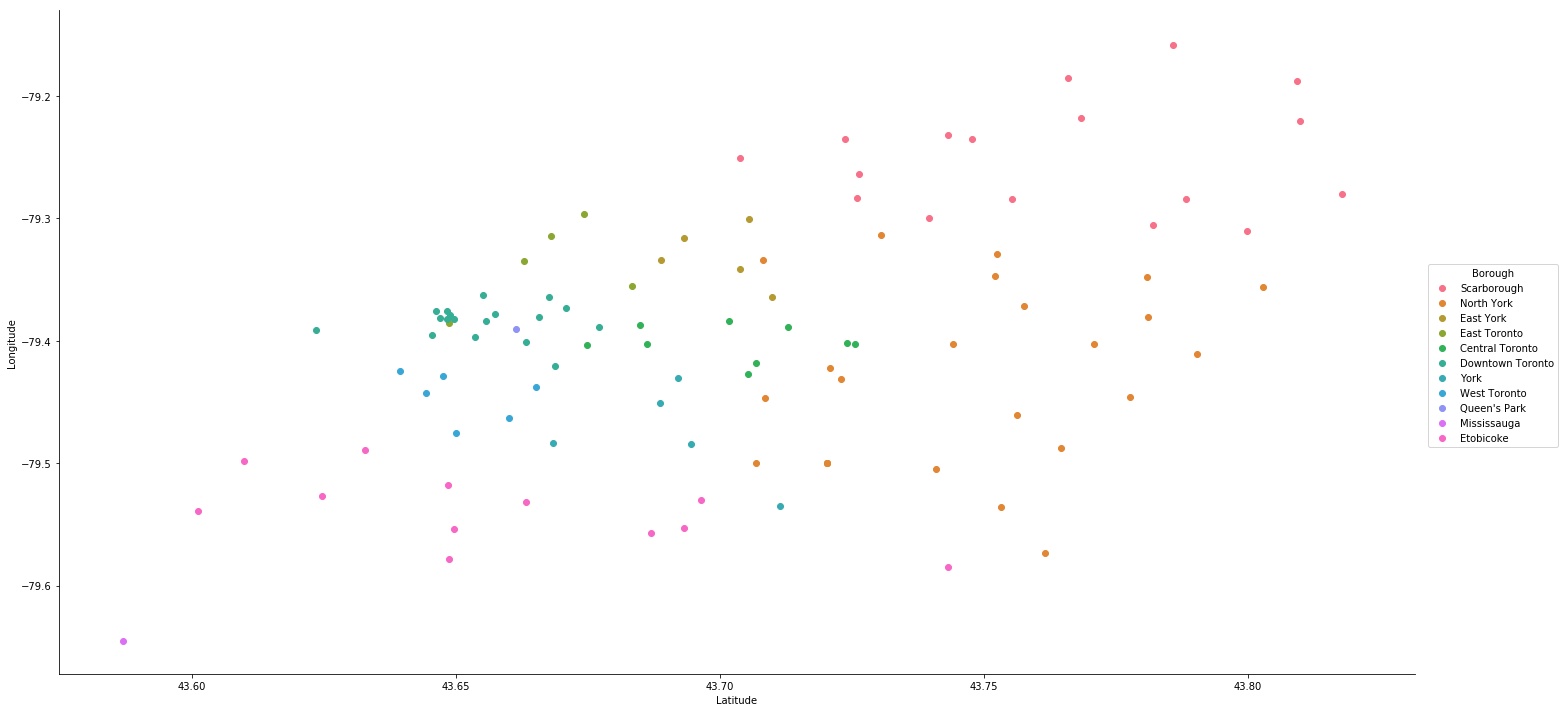

In [15]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
fg = sns.FacetGrid(data=df, hue='Borough', aspect=2, size = 10)
fg.map(plt.scatter, 'Latitude', 'Longitude').add_legend()

# Clustering Neighborhoods

In [24]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.



In [26]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import random

## Show map colored by Borough

In [27]:
neighbourhoods = list(df['Borough'].unique())
colors_array = cm.rainbow(np.linspace(0, 1, len(neighbourhoods)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow_dark = [colors.rgb2hex(i) for i in colors_array / 3]

latitude = df['Latitude'].mean()
longitude = df['Longitude'].mean()
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow_dark[neighbourhoods.index(borough)],
        fill=True,
        fill_color=rainbow[neighbourhoods.index(borough)],
        fill_opacity=0.9,
        parse_html=False).add_to(map_toronto)  

map_toronto

## Fit for 5 clusters

In [28]:
from sklearn.cluster import KMeans
n_clusters = 5
coordinates_df = df[['Latitude','Longitude']]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coordinates_df)
cluster_df = df.copy()
cluster_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
cluster_df.head(12)

,Cluster Labels,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,4,M1B,Scarborough,"Rouge, Malvern,",43.809770,-79.220840
1,4,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union,",43.785730,-79.158750
2,4,M1E,Scarborough,"Guildwood, Morningside, West Hill,",43.765932,-79.185354
3,4,M1G,Scarborough,"Woburn,",43.768359,-79.217590
4,4,M1H,Scarborough,"Cedarbrae,",43.747758,-79.235186
5,4,M1J,Scarborough,"Scarborough Village,",43.743125,-79.231750
6,0,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park,",43.726245,-79.263670
7,0,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge,",43.725990,-79.283270
8,4,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West,",43.723575,-79.234976
9,0,M1N,Scarborough,"Birch Cliff, Cliffside West,",43.703793,-79.250598


## Show map colored by Clusters

In [30]:
colors_array_cluster = cm.rainbow(np.linspace(0, 1, n_clusters))
rainbow_cluster = [colors.rgb2hex(i) for i in colors_array_cluster]
rainbow_cluster_dark = [colors.rgb2hex(i) for i in colors_array_cluster / 3]

map_toronto_clustered = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood, cluster in zip(cluster_df['Latitude'], cluster_df['Longitude'], cluster_df['Borough'], cluster_df['Neighbourhood'], cluster_df['Cluster Labels']):
    label = '#{}: {}, {}'.format(cluster, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow_cluster_dark[cluster-1],
        fill=True,
        fill_color=rainbow_cluster[cluster-1],
        fill_opacity=0.9,
        parse_html=False).add_to(map_toronto_clustered)  

map_toronto_clustered